This implementation is based on two implementations:

- [PyTorch official Reinforcement Learning example](https://github.com/pytorch/examples/blob/main/reinforcement_learning/reinforce.py)
- [Udacity](https://github.com/udacity/deep-reinforcement-learning/)

# Monte Carlo Methods

In the first section, we will use Monte Carlo (MC) algorithms to teach an agent how to play Blackjack. 

We begin by importing the necessary packages.

https://github.com/openai/gym/blob/master/gym/envs/toy_text/blackjack.py

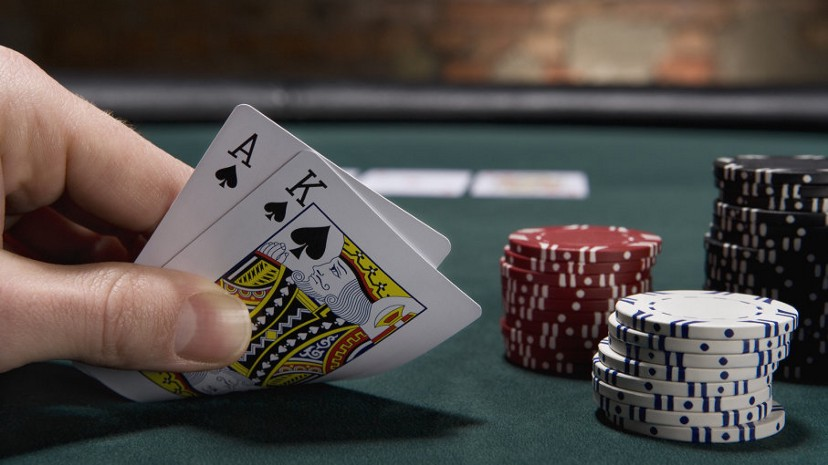

In [25]:
import sys
import gym
import numpy as np
from collections import defaultdict, deque
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.distributions import Categorical

from pathlib import Path
import datetime
import json
import imageio

!pip install imageio-ffmpeg
!pip install gym[classic_control]

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 67.3 MB/s eta 0:00:00


### Some plotting utilities.

In [2]:
import numpy as np
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

def plot_blackjack_values(V):

    def get_Z(x, y, usable_ace):
        if (x,y,usable_ace) in V:
            return V[x,y,usable_ace]
        else:
            return 0

    def get_figure(usable_ace, ax):
        x_range = np.arange(11, 22)
        y_range = np.arange(1, 11)
        X, Y = np.meshgrid(x_range, y_range)
        
        Z = np.array([get_Z(x,y,usable_ace) for x,y in zip(np.ravel(X), np.ravel(Y))]).reshape(X.shape)

        surf = ax.plot_surface(X, Y, Z, rstride=1, cstride=1, cmap=plt.cm.coolwarm, vmin=-1.0, vmax=1.0)
        ax.set_xlabel('Player\'s Current Sum')
        ax.set_ylabel('Dealer\'s Showing Card')
        ax.set_zlabel('State Value')
        ax.view_init(ax.elev, -120)

    fig = plt.figure(figsize=(20, 20))
    ax = fig.add_subplot(211, projection='3d')
    ax.set_title('Usable Ace')
    get_figure(True, ax)
    ax = fig.add_subplot(212, projection='3d')
    ax.set_title('No Usable Ace')
    get_figure(False, ax)
    plt.show()

def plot_policy(policy):

    def get_Z(x, y, usable_ace):
        if (x,y,usable_ace) in policy:
            return policy[x,y,usable_ace]
        else:
            return 1

    def get_figure(usable_ace, ax):
        x_range = np.arange(11, 22)
        y_range = np.arange(10, 0, -1)
        X, Y = np.meshgrid(x_range, y_range)
        Z = np.array([[get_Z(x,y,usable_ace) for x in x_range] for y in y_range])
        surf = ax.imshow(Z, cmap=plt.get_cmap('Pastel2', 2), vmin=0, vmax=1, extent=[10.5, 21.5, 0.5, 10.5])
        plt.xticks(x_range)
        plt.yticks(y_range)
        plt.gca().invert_yaxis()
        ax.set_xlabel('Player\'s Current Sum')
        ax.set_ylabel('Dealer\'s Showing Card')
        ax.grid(color='w', linestyle='-', linewidth=1)
        divider = make_axes_locatable(ax)
        cax = divider.append_axes("right", size="5%", pad=0.1)
        cbar = plt.colorbar(surf, ticks=[0,1], cax=cax)
        cbar.ax.set_yticklabels(['0 (STICK)','1 (HIT)'])
            
    fig = plt.figure(figsize=(15, 15))
    ax = fig.add_subplot(121)
    ax.set_title('Usable Ace')
    get_figure(True, ax)
    ax = fig.add_subplot(122)
    ax.set_title('No Usable Ace')
    get_figure(False, ax)
    plt.show()


### Explore BlackjackEnv

In [3]:
env = gym.make('Blackjack-v1')

/usr/local/lib/python3.8/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.8/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(


Each state is a 3-tuple of:
- the player's current sum $\in \{0, 1, \ldots, 31\}$,
- the dealer's face up card $\in \{1, \ldots, 10\}$, and
- whether or not the player has a usable ace (`no` $=0$, `yes` $=1$).

The agent has two potential actions:

```
    STICK = 0
    HIT = 1
```
Verify this by running the code cell below.

In [4]:
print(env.observation_space)
print(env.action_space)

Tuple(Discrete(32), Discrete(11), Discrete(2))
Discrete(2)


\Execute the code cell below to play Blackjack with a random policy. Run the cell multiple times, or change the number of iterations of for loop to get some experience with the output returned as the agent interacts with the envionment. 

(_current code plays Blackjack three times._)

In [5]:
for i_episode in range(15):
    state = env.reset()
    while True:
        print('State: ', state)
        action = env.action_space.sample()
        print('Action: stick') if action == 0 else print('Action: hit')
        state, reward, done, info = env.step(action)
        if done:
            print('End game! Reward: ', reward)
            print('You won :)\n') if reward > 0 else print('You did not win :(\n')
            break

State:  (18, 1, False)
Action: stick
End game! Reward:  1.0
You won :)

State:  (15, 9, False)
Action: hit
End game! Reward:  -1.0
You did not win :(

State:  (16, 10, False)
Action: hit
State:  (17, 10, False)
Action: hit
End game! Reward:  -1.0
You did not win :(

State:  (6, 10, False)
Action: stick
End game! Reward:  -1.0
You did not win :(

State:  (12, 6, False)
Action: stick
End game! Reward:  -1.0
You did not win :(

State:  (15, 2, False)
Action: stick
End game! Reward:  1.0
You won :)

State:  (18, 10, False)
Action: hit
State:  (20, 10, False)
Action: stick
End game! Reward:  0.0
You did not win :(

State:  (13, 5, False)
Action: stick
End game! Reward:  1.0
You won :)

State:  (11, 6, False)
Action: hit
State:  (21, 6, False)
Action: hit
End game! Reward:  -1.0
You did not win :(

State:  (11, 7, False)
Action: stick
End game! Reward:  -1.0
You did not win :(

State:  (17, 7, True)
Action: hit
State:  (13, 7, False)
Action: stick
End game! Reward:  1.0
You won :)

State:  (

### Part 1: MC Prediction

In this section, we will explore the MC prediction (for estimating the action-value function).  

We will begin by investigating a policy where the player _almost_ always sticks if the sum of his cards exceeds 18.  In particular, the player selects action `STICK` with 80% probability if the sum is greater than 18; and, if the sum is 18 or below, then selects action `HIT` with 80% probability.  The function `generate_episode_from_limit_stochastic` samples an episode using this policy. 

The function accepts as **input**:
- `bj_env`: This is an instance of OpenAI Gym's Blackjack environment.

It returns as **output**:
- `episode`: This is a list of (state, action, reward) tuples (of tuples) and corresponds to $(S_0, A_0, R_1, \ldots, S_{T-1}, A_{T-1}, R_{T})$, where $T$ is the final time step.  In particular, `episode[i]` returns $(S_i, A_i, R_{i+1})$.

In [6]:
def generate_episode_from_limit_stochastic(bj_env):
    episode = []
    state = bj_env.reset()
    while True:
        probs = [0.8, 0.2] if state[0] > 18 else [0.2, 0.8]
        action = np.random.choice(np.arange(2), p=probs)
        next_state, reward, done, info = bj_env.step(action)
        episode.append((state, action, reward))
        state = next_state
        if done:
            break
    return episode

Execute the code cell below to play Blackjack with the policy. 
Run the cell multiple times, or change the number of iterations of for loop to get some familiarity with the output of the `generate_episode_from_limit_stochastic` function.

(_current code plays Blackjack three times._)

In [7]:
for i in range(10):
    print(generate_episode_from_limit_stochastic(env))

[((12, 5, True), 0, 1.0)]
[((12, 10, False), 1, 0.0), ((18, 10, False), 1, -1.0)]
[((16, 10, False), 1, -1.0)]
[((4, 10, False), 1, 0.0), ((10, 10, False), 1, 0.0), ((18, 10, False), 1, -1.0)]
[((8, 9, False), 0, -1.0)]
[((17, 9, False), 0, 0.0)]
[((17, 10, False), 1, 0.0), ((21, 10, False), 0, 0.0)]
[((14, 9, False), 1, -1.0)]
[((20, 3, False), 0, 1.0)]
[((5, 10, False), 0, -1.0)]


Now, we are ready to write our own implementation of MC prediction.

The algorithm has three arguments:
- `env`: This is an instance of an OpenAI Gym environment.
- `num_episodes`: This is the number of episodes that are generated through agent-environment interaction.
- `generate_episode`: This is a function that returns an episode of interaction.

The algorithm returns as output:
- `Q`: This is a dictionary (of one-dimensional arrays) where `Q[s][a]` is the estimated action value corresponding to state `s` and action `a`.

In [8]:
# print(env.action_space.)
def mc_prediction_q(env, num_episodes, generate_episode, gamma = 0.5):
    # initialize empty dictionaries of arrays
    returns_sum = defaultdict(lambda: np.zeros(env.action_space.n))
    N = defaultdict(lambda: np.zeros(env.action_space.n))
    Q = defaultdict(lambda: np.zeros(env.action_space.n))
    # loop over episodes
    for i_episode in range(1, num_episodes+1):
        # monitor progress
        if i_episode % 1000 == 0:
            print("\rEpisode {}/{}.".format(i_episode, num_episodes), end="")
            sys.stdout.flush()
        
        ## TODO: complete the function
        ### HINT: generate an episode and seperate the states, action and rewards tuples
        episode = generate_episode(env)
        states, actions, rewards = zip(*episode) # TODO: Seperate the state, action and reward tuples from a single episode
        discount_factors = np.array([gamma**i for i in range(len(rewards)+1)]) 

        for i, state in enumerate(states):
            N[state][actions[i]] += 1.0
            returns_sum[state][actions[i]] += sum(rewards[i:] * discount_factors[:-(1+i)])  # TODO: Calculate returns corresponding to each state and action
            Q[state][actions[i]] = returns_sum[state][actions[i]]/N[state][actions[i]]

    return Q
mc_prediction_q(env, 1, generate_episode_from_limit_stochastic)

defaultdict(<function __main__.mc_prediction_q.<locals>.<lambda>()>,
            {(5, 4, False): array([ 0. , -0.5]),
             (10, 4, False): array([-1.,  0.])})

Use the cell below to obtain the action-value function estimate $Q$. The corresponding state-value function is also plotted.

Episode 500000/500000.

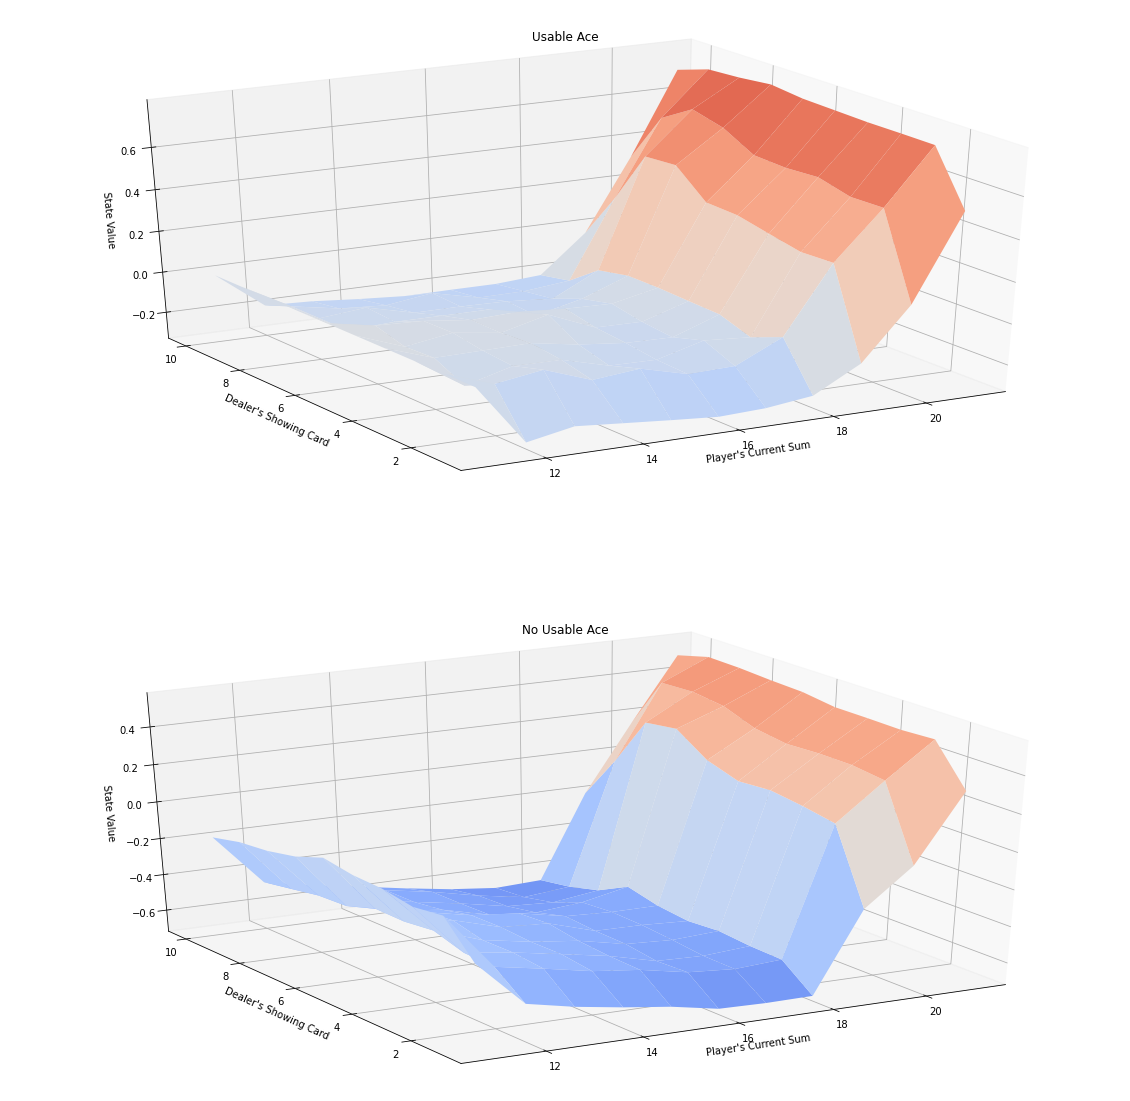

In [ ]:
# obtain the action-value function
Q = mc_prediction_q(env, 500000, generate_episode_from_limit_stochastic)

# obtain the corresponding state-value function
V_to_plot = dict((k,(k[0]>18)*(np.dot([0.8, 0.2],v)) + (k[0]<=18)*(np.dot([0.2, 0.8],v))) for k, v in Q.items())

# plot the state-value function
plot_blackjack_values(V_to_plot)

### Part 2: MC Control

In this section, we will write an implementation of constant-$\alpha$ MC control.  

The algorithm has three arguments:
- `env`: This is an instance of an OpenAI Gym environment.
- `num_episodes`: This is the number of episodes that are generated through agent-environment interaction.
- `alpha`: This is the step-size parameter for the update step.

The algorithm returns as output:
- `Q`: This is a dictionary (of one-dimensional arrays) where `Q[s][a]` is the estimated action value corresponding to state `s` and action `a`.
- `policy`: This is a dictionary where `policy[s]` returns the action that the agent chooses after observing state `s`.

In [9]:
def generate_episode_from_Q(env, Q, epsilon, nA):
    """ generates an episode from following the epsilon-greedy policy """
    episode = []
    state = env.reset()
    while True:
        action = np.random.choice(np.arange(nA), p=get_probs(Q[state], epsilon, nA)) if state in Q else env.action_space.sample()
        next_state, reward, done, info = env.step(action)
        episode.append((state, action, reward))
        state = next_state
        if done:
            break
    return episode

def get_probs(Q_s, epsilon, nA):
    """ obtains the action probabilities corresponding to epsilon-greedy policy """
    policy_s = np.ones(nA) * epsilon / nA
    best_a = np.argmax(Q_s)
    policy_s[best_a] = 1 - epsilon + (epsilon / nA)
    return policy_s

def update_Q(episode, Q, alpha, gamma = 1.0):
    """ updates the action-value function estimate using the most recent episode """
    states, actions, rewards = zip(*episode)
    print(rewards)
    discount_factors = np.array([gamma**i for i in range(len(rewards)+1)]) 
    for i, state in enumerate(states):
        old_Q = Q[state][actions[i]] 
        Gt = sum(rewards[i:] * discount_factors[:-(1+i)])   #Return from state i to the end.
        Q[state][actions[i]] =  old_Q + alpha * (Gt - old_Q) # TODO: Update the Q values using old estimate and the new estimate, remember Q_new = Q_old + alpha(Recent_Return - Q_old)
    return Q

In [10]:
nA = 10
epsilon = 0.1
A = np.ones(nA, dtype=float) * epsilon / nA
best_a = 2
A[best_a] = 1 - epsilon + (epsilon / nA)

print(A)

[0.01 0.01 0.91 0.01 0.01 0.01 0.01 0.01 0.01 0.01]


In [11]:
def mc_control(env, num_episodes, alpha,  epsilon=0.3):
    nA = env.action_space.n
    # initialize empty dictionary of arrays
    Q = defaultdict(lambda: np.zeros(nA))
    policy = defaultdict(lambda: np.ones(nA) / nA)
    
    # loop over episodes
    for i_episode in range(num_episodes):
        # monitor progress
        if (i_episode + 1) % 1000 == 0:
            print("\rEpisode {}/{}.".format(i_episode + 1, num_episodes), end="")
            sys.stdout.flush()
            
        episode = generate_episode_from_Q(env, Q, epsilon, nA)
        Q = update_Q(episode, Q, alpha)
        
    policy = dict((k, np.argmax(v)) for k, v in Q.items())
    return policy, Q

Use the cell below to obtain the estimated optimal policy and action-value function.  

You can try your own values for the `num_episodes` and `alpha` parameters.

In [ ]:
# obtain the estimated optimal policy and action-value function
policy, Q = mc_control(env, 500000, 0.02)

Output streaming troncato alle ultime 5000 righe.
(-1.0,)
(0.0, 0.0, 1.0)
(0.0, -1.0)
(-1.0,)
(0.0, 1.0)
(1.0,)
(-1.0,)
(0.0, -1.0)
(-1.0,)
(1.0,)
(-1.0,)
(0.0, -1.0)
(0.0, 0.0, 1.0)
(0.0, 1.0)
(0.0, -1.0)
(-1.0,)
(1.0,)
(-1.0,)
(-1.0,)
(0.0, 1.0)
(1.0,)
(0.0, 1.0)
(-1.0,)
(-1.0,)
(-1.0,)
(1.0,)
(-1.0,)
(1.0,)
(0.0, -1.0)
(0.0, -1.0)
(0.0, -1.0)
(0.0, -1.0)
(1.0,)
(0.0, 0.0)
(0.0, 0.0, 0.0)
(0.0, -1.0)
(0.0, 1.0)
(0.0, -1.0)
(-1.0,)
(0.0,)
(0.0, -1.0)
(1.0,)
(1.0,)
(1.0,)
(-1.0,)
(0.0, -1.0)
(0.0, 1.0)
(0.0, -1.0)
(-1.0,)
(0.0, 0.0)
(-1.0,)
(-1.0,)
(0.0, 0.0)
(-1.0,)
(0.0, 1.0)
(-1.0,)
(1.0,)
(0.0, -1.0)
(-1.0,)
(-1.0,)
(0.0,)
(-1.0,)
(-1.0,)
(-1.0,)
(0.0, -1.0)
(0.0, -1.0)
(-1.0,)
(0.0, 0.0)
(1.0,)
(0.0, 1.0)
(0.0,)
(0.0, 0.0)
(0.0, 1.0)
(-1.0,)
(0.0, -1.0)
(0.0, 1.0)
(0.0, 1.0)
(-1.0,)
(-1.0,)
(1.0,)
(1.0,)
(0.0, -1.0)
(1.0,)
(-1.0,)
(1.0,)
(-1.0,)
(1.0,)
(0.0,)
(-1.0,)
(1.0,)
(-1.0,)
(0.0, 0.0, 1.0)
(1.0,)
(-1.0,)
(-1.0,)
(0.0,)
(0.0, -1.0)
(-1.0,)
(-1.0,)
(0.0, -1.0)
(0.0, 0.0, 0.0

Next, we plot the corresponding state-value function.

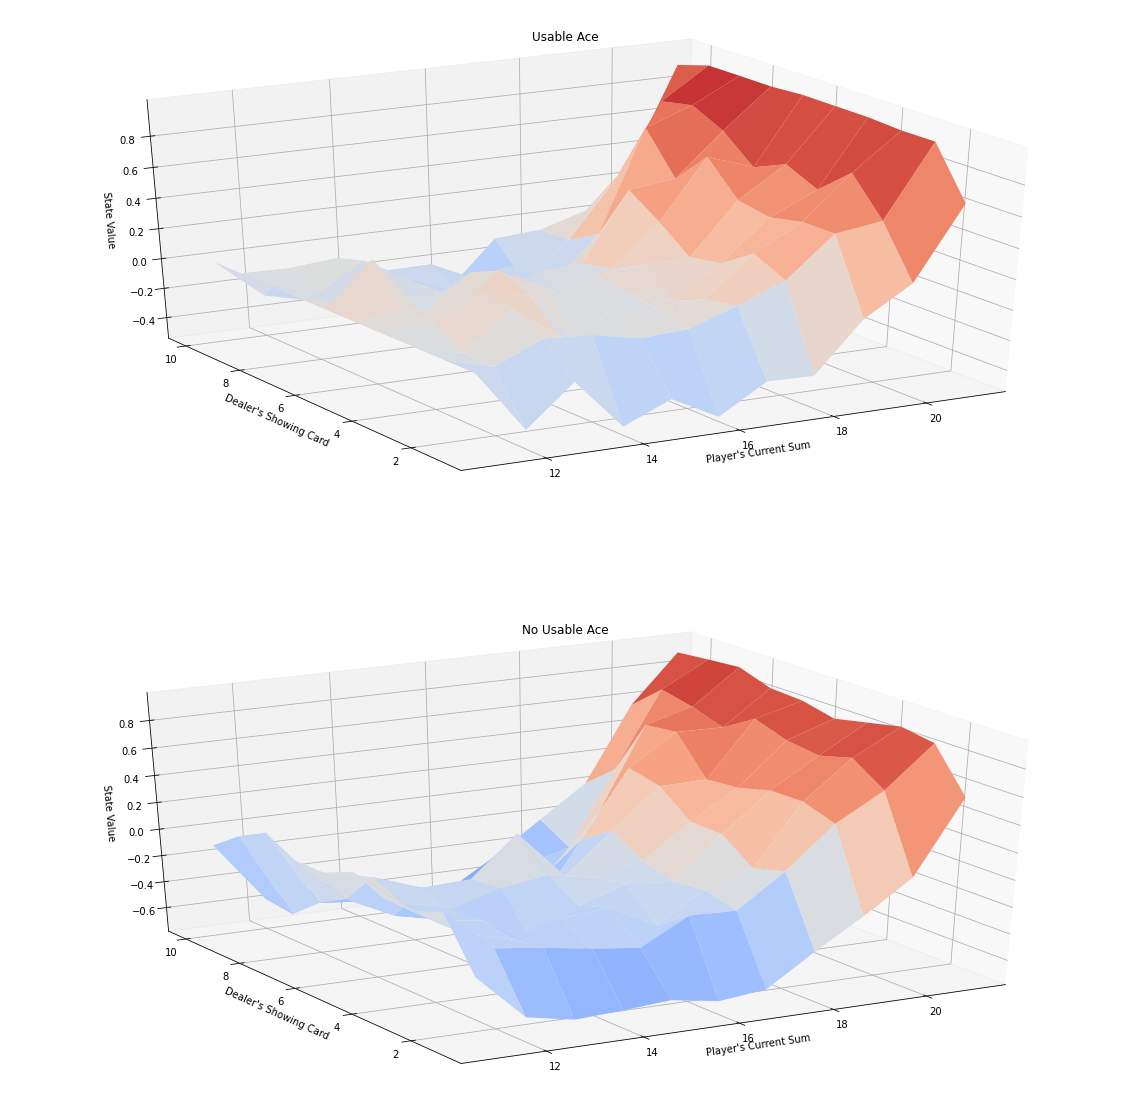

In [ ]:
# obtain the corresponding state-value function
V = dict((k,np.max(v)) for k, v in Q.items())

# plot the state-value function
plot_blackjack_values(V)

Finally, we visualize the policy that is estimated to be optimal.

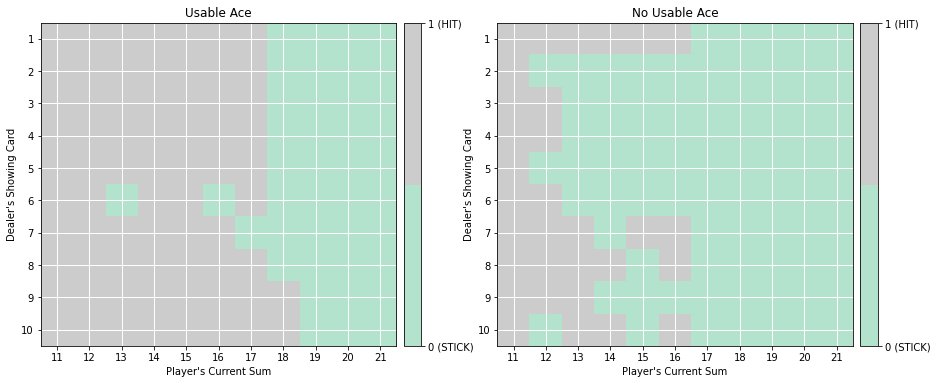

In [ ]:
# plot the policy
plot_policy(policy)

# Monte Carlo Policy Gradient (REINFORCE)

In this second section, we will use REINFORCE algorithm to teach an agent how to balance the pole attached to a moving cart. 

We begin by creating an environment. 

Now the state is no more discrete but a vector of continous numbers.

Each state consists of:
- Cart's position, $[-4.8, 4.8]$
- Cart's velocity, $[-∞, +∞]$
- Pole angle,$[-0.418, 0.418]$
- Pole angular velocity $[-∞, +∞]$.

The agent has two potential actions:

```
    Push the cart to the left = 0
    Push the cart to the right = 1
```
Verify this by running the code cell below.

The agent get a reward of +1 at each timestep if the episode is not `done`. An Episode is `done` when the pole deviates more than 15 degrees from vertical.

### Part 1: Explore the environment

In [37]:
env = gym.make('CartPole-v1')
# Get the state space and action space
s_size = env.observation_space.shape[0]
a_size = env.action_space.n

In [38]:
print("STATE SPACE \n")
print("The State Space is: ", s_size)
print("Sample state", env.observation_space.sample()) # Get a random observation

STATE SPACE 

The State Space is:  4
Sample state [-1.7180221e+00 -1.4768776e+37 -3.8119519e-01  1.0787031e+38]


In [16]:
print("\n ACTION SPACE \n")
print("The Action Space is: ", a_size)
print("Sample action", env.action_space.sample()) # Take a random action


 ACTION SPACE 

The Action Space is:  2
Sample action 0


### Part 2: Build the Policy
Next, we define the neural network below that encodes the policy.
we want to build the NN architecture with:

- Two fully connected layers (fc1 and fc2).
- ReLU as activation function of fc1
- Softmax to output a probability distribution over actions

The `act` method of the `Policy` class takes as an **input**: 
- state 

It returns as **output**:
- action
- log porbability of taking the action

In [91]:
class Policy(nn.Module):
    def __init__(self, env, h_size=16):
        super(Policy, self).__init__()
        self.env = env
        
        self.s_size = env.observation_space.shape[0]
        self.a_size = env.action_space.n
        self.h_size = h_size
        
        self.model = nn.Sequential(
            nn.Linear(self.s_size, self.h_size),
            nn.ReLU(),
            nn.Linear(self.h_size, self.a_size),
            nn.Softmax()
        )
        # TODO: Create two fully connected layers
        
    def forward(self, state):
        # TODO: Define the forward pass
        # state goes to fc1 then we apply ReLU activation function

        # fc1 outputs goes to fc2
        x = self.model(state)
        # We output the result of softmax
        return x
    
    def act(self, state):
        state = torch.from_numpy(state).float().unsqueeze(0)
        action_probs = self.forward(state).cpu()
        dist = Categorical(action_probs)
        action = dist.sample()
        return action.item(), dist.log_prob(action)

In [100]:
policy = Policy(env,2)
optimizer = optim.Adam(policy.parameters(), lr=1e-2)

In [101]:
a, b = policy.act(env.reset())

### Part 3: Build the Reinforce Training Algorithm


In [102]:
def reinforce(max_iterations=1000, max_t=1000, gamma=0.99, print_every=100, treshold = 450):
    scores = []
    scores_deque = deque(maxlen=100)

    # Collect trajectory    
    for i_iteration in range(1, max_iterations + 1):
        state = env.reset()# TODO: reset the environment
        rewards = []
        saved_log_probs = []
        
        for t in range(max_t):
            # Sample the action from current policy
            action, log_prob = policy.act(state) # TODO get the action
            state, reward, done, _ = env.step(action) # TODO: take an env step
            rewards.append(reward)
            saved_log_probs.append(log_prob)
            if done:
                break
        # Calculate total expected reward
        scores_deque.append(sum(rewards))
        scores.append(sum(rewards))
        

        # Recalculate the total reward applying discounted factor
        ## Here, we calculate discounts for instance [0.99^1, 0.99^2, 0.99^3, ..., 0.99^len(rewards)]
        discounts = [gamma ** i for i in range(len(rewards))]
        ## We calculate the return by sum(gamma[t] * reward[t]) 
        R = sum([a*b for a,b in zip(  discounts, rewards )]) # TODO: what do we need to put in zip() remember that we calculate gamma[t] * reward[t]

        # Calculate the loss 
        policy_loss = []
        for log_prob in saved_log_probs:
            # Note that we are using Gradient Ascent, not Descent. So we need to calculate it with negative rewards.
            policy_loss.append(-log_prob * R)
        # After that, we concatenate whole policy loss in 0th dimension
        policy_loss = torch.cat(policy_loss).sum()
        
        # Backpropagation
        optimizer.zero_grad()
        policy_loss.backward()
        optimizer.step()        
        
        if i_iteration % print_every == 0:
            print('\nEpisode {}\tAverage Score: {:.2f}'.format(i_iteration, np.mean(scores_deque)))
        if np.mean(scores_deque)>=treshold:
            print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(i_iteration-100, np.mean(scores_deque)))
            break
    
    return scores

### Part 4: Train and observe the results

In [103]:
scores = reinforce(max_iterations=3000, treshold=450)


Episode 100	Average Score: 16.74

Episode 200	Average Score: 21.16

Episode 300	Average Score: 25.28

Episode 400	Average Score: 29.21

Episode 500	Average Score: 34.64

Episode 600	Average Score: 42.52

Episode 700	Average Score: 61.32

Episode 800	Average Score: 80.02

Episode 900	Average Score: 124.68

Episode 1000	Average Score: 134.64

Episode 1100	Average Score: 277.02

Episode 1200	Average Score: 207.05

Episode 1300	Average Score: 135.64

Episode 1400	Average Score: 133.14

Episode 1500	Average Score: 160.68

Episode 1600	Average Score: 375.57

Episode 1700	Average Score: 268.37

Episode 1800	Average Score: 114.86

Episode 1900	Average Score: 87.14

Episode 2000	Average Score: 86.42

Episode 2100	Average Score: 117.47

Episode 2200	Average Score: 121.43

Episode 2300	Average Score: 146.90

Episode 2400	Average Score: 173.14

Episode 2500	Average Score: 175.25

Episode 2600	Average Score: 113.91

Episode 2700	Average Score: 187.98

Environment solved in 2682 episodes!	Average S

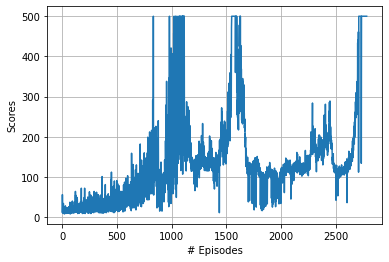

In [104]:
f = plt.figure()
ax = f.add_subplot(111)
plt.plot(range(1, len(scores) + 1), scores)
plt.xlabel('# Episodes')
plt.ylabel('Scores')
plt.grid(visible=True)
plt.show()

In [99]:
def record_video(env, policy, out_directory, fps=30):
  images = []  
  done = False
  state = env.reset()
  img = env.render(mode='rgb_array')
  images.append(img)
  while not done:
    # Take the action (index) that have the maximum expected future reward given that state
    action, _ = policy.act(state)
    state, reward, done, info = env.step(action) # We directly put next_state = state for recording logic
    img = env.render(mode='rgb_array')
    images.append(img)
  imageio.mimsave(out_directory, [np.array(img) for i, img in enumerate(images)], fps=fps)

record_video(env, policy, Path("/animation.mp4"), 30)